In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested, daily_vaccinations, population_vaccinated
from phe import *
from phe import map_data as phe_map_data, latest_changes
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

In [2]:
latest_changes(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum)

Latest for England:
8,462 cases (7 day average) as of Sun 20 Jun, +303.0 since Sat 19 Jun
188 hospitalised (7 day average) as of Wed 23 Jun, +5.3 since Tue 22 Jun
11 died (7 day average) as of Sun 20 Jun, +1.3 since Sat 19 Jun


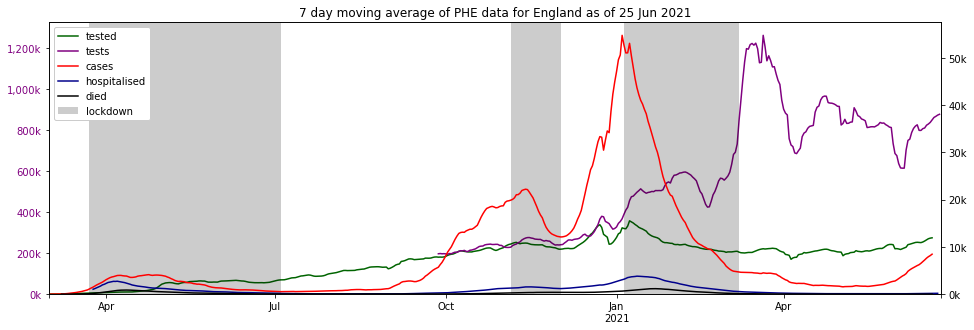

In [3]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

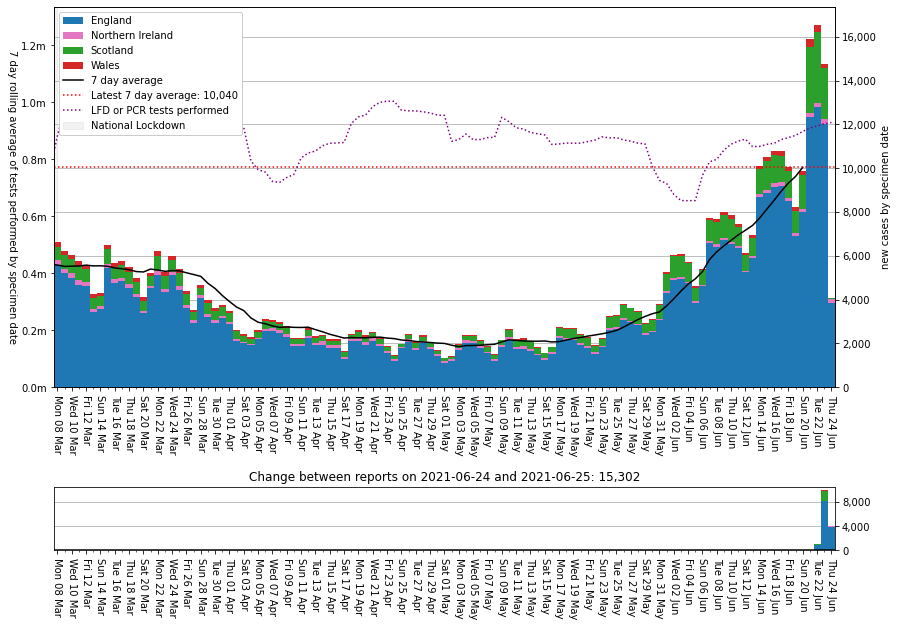

In [4]:
plot_areas(for_date, 'cases_nations', earliest=lockdown3[1], date_format='%a %d %b')

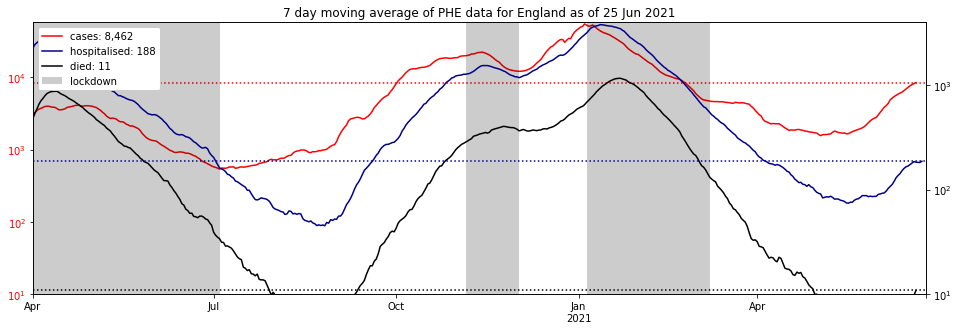

In [5]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

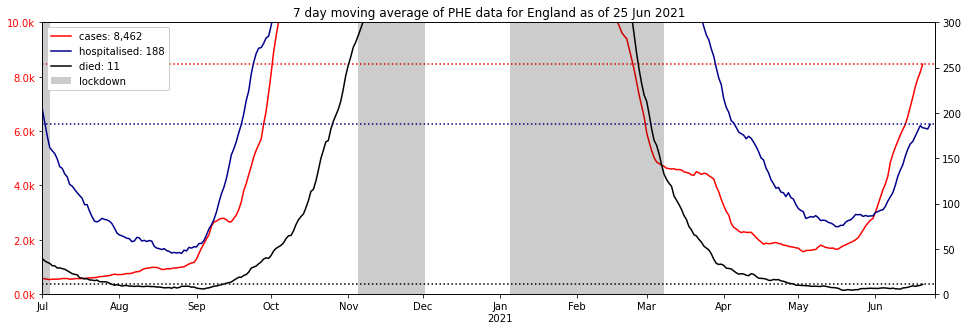

In [6]:
plot_summary(earliest_date='2020-07-01', show_latest='lines',
             left_series=(s.new_cases_sum,), left_formatter=per0k_formatter, left_ymax=10_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=300)

In [7]:
vaccination_changes()

,,Complete (Total),First Dose (Total),Second Dose (Total),Complete (New),First Dose (New),Second Dose (New)
,,,,,,,
England,24 Jun 21,"+27,011,033","+36,767,328","+27,011,033","+136,679","+202,390","+136,679"
Northern Ireland,24 Jun 21,"+836,164","+1,152,720","+836,164","+5,658","+2,518","+5,658"
Scotland,24 Jun 21,"+2,647,397","+3,709,801","+2,647,397","+15,864","+14,498","+15,864"
Wales,24 Jun 21,"+1,591,322","+2,248,012","+1,591,322","+19,612","+2,128","+19,612"


,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,27011033.0,36767328.0,9756295.0,56286961,47.988082,17.333135,34.678783
1,Northern Ireland,N92000002,836164.0,1152720.0,316556.0,1893667,44.155810,16.716561,39.127629
2,Scotland,S92000003,2647397.0,3709801.0,1062404.0,5463300,48.457837,19.446196,32.095968
3,Wales,W92000004,1591322.0,2248012.0,656690.0,3152879,50.472029,20.828265,28.699706


'partial: 43,877,861 (65.7%), full: 32,085,916'

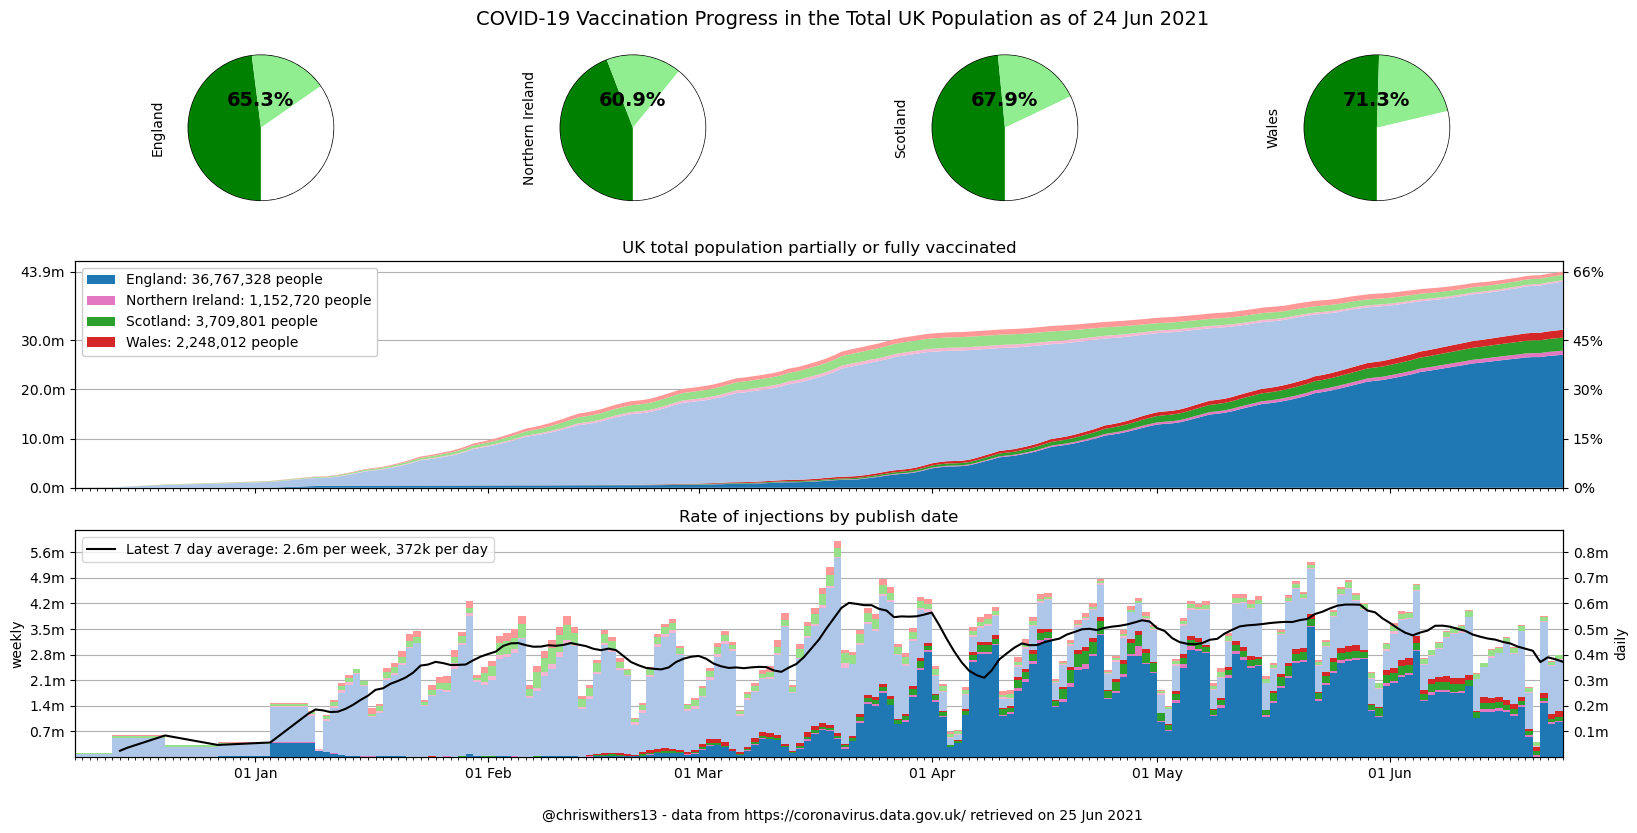

In [8]:
results = vaccination_dashboard()
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

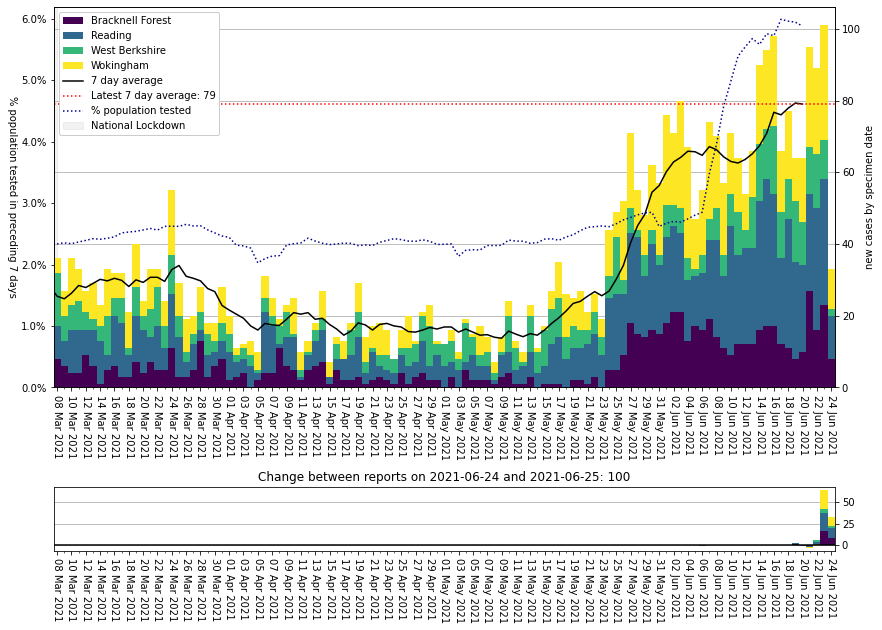

In [9]:
plot_areas(for_date, areas=my_areas, earliest=lockdown3[1], lines=unique_people_tested)

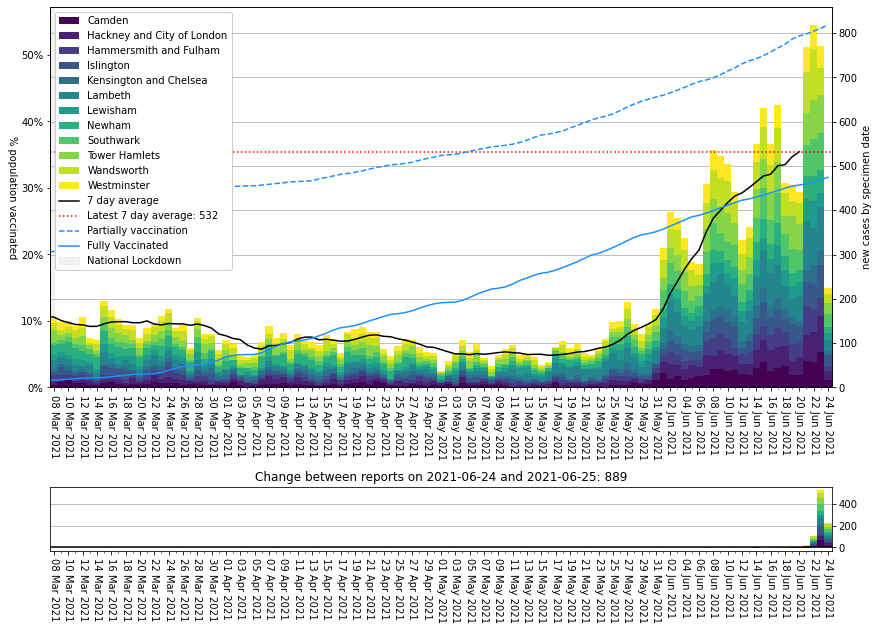

In [10]:
plot_areas(for_date, areas=london_areas, earliest=lockdown3[1], lines=population_vaccinated)

In [11]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [12]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
S12000042,Dundee City,476.158586,711.0,2021-06-24
E07000120,Hyndburn,466.419061,378.0,2021-06-24
S12000010,East Lothian,464.095621,497.0,2021-06-24
E06000008,Blackburn with Darwen,398.140231,596.0,2021-06-24
S12000019,Midlothian,390.439109,361.0,2021-06-24
S12000036,City of Edinburgh,368.811080,1936.0,2021-06-24
E07000117,Burnley,363.247863,323.0,2021-06-24
E08000003,Manchester,361.213910,1997.0,2021-06-24
E08000006,Salford,346.940510,898.0,2021-06-24


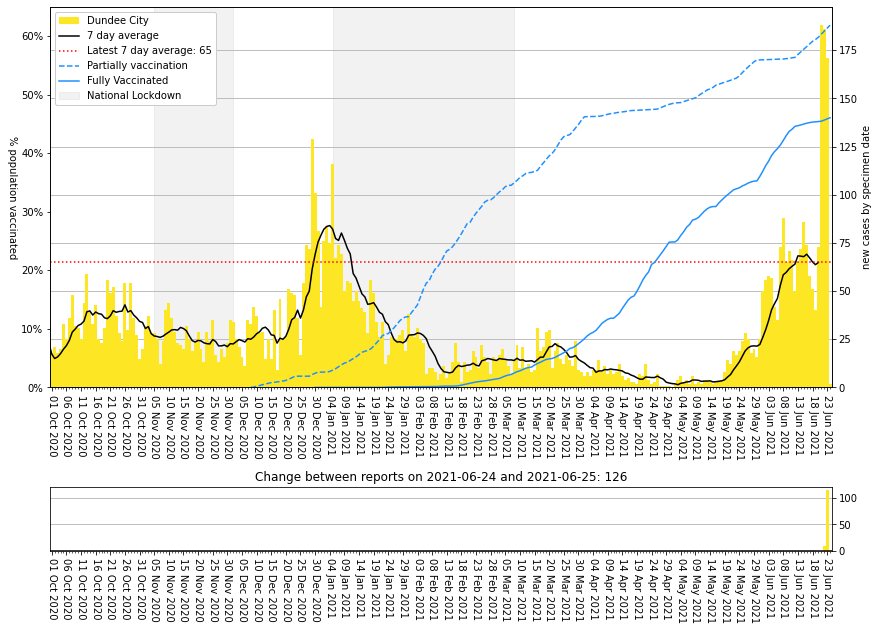

In [13]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=population_vaccinated)

In [14]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000003,Manchester,361.213910,1997.0,2021-06-24
E08000035,Leeds,248.506252,1971.0,2021-06-24
S12000036,City of Edinburgh,368.811080,1936.0,2021-06-24
E08000025,Birmingham,143.630848,1640.0,2021-06-24
S12000049,Glasgow City,243.713672,1543.0,2021-06-24
E06000047,County Durham,280.327640,1486.0,2021-06-24
E08000012,Liverpool,289.734601,1443.0,2021-06-24
E08000010,Wigan,316.130249,1039.0,2021-06-24
E08000021,Newcastle upon Tyne,341.456971,1034.0,2021-06-24


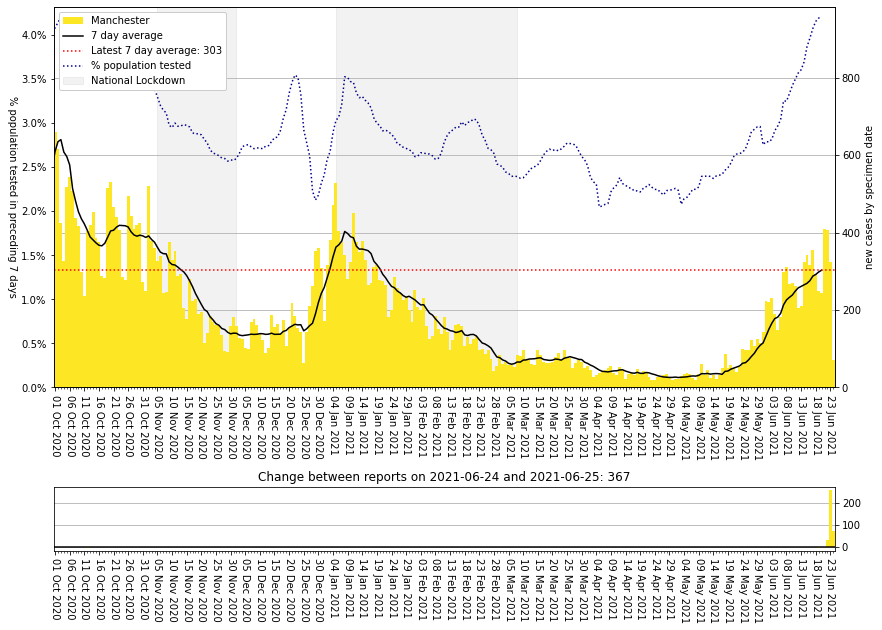

In [15]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested)

In [16]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 2.5
phe_max = 0.5

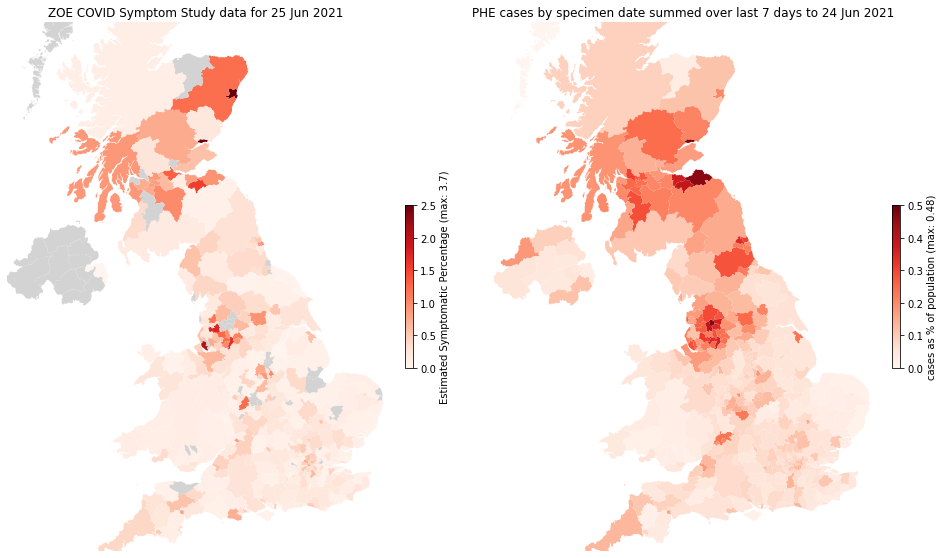

In [17]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [18]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...